<a href="https://colab.research.google.com/github/thimeshaA/BrineXCompass-M2-Demand-PriceForecasting/blob/main/Demand_Price_Forecasting_(Supervised).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup & Imports

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import json

# ML libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Load Datasets

**Dataset 1:** `seller_recommendation_training_data.xlsx`
- Used for: Model 1 (Seller RL), Model 3 (Price Prediction)

**Dataset 2:** `monthly_market_aggregates.xlsx`
- Used for: Model 2 (Harvest Timing RL), Model 4 (Forecasting)

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Load datasets
print("Loading datasets...\n")
BASE_PATH = '/content/drive/MyDrive/BrineXCompass'

df_transactions = pd.read_excel(f'{BASE_PATH}/seller_recommendation_training_data.xlsx')
print(f"✓ Dataset 1 (Transactions): {df_transactions.shape[0]} rows, {df_transactions.shape[1]} columns")

df_market = pd.read_excel(f'{BASE_PATH}/monthly_market_aggregates.xlsx')
print(f"✓ Dataset 2 (Market Aggregates): {df_market.shape[0]} rows, {df_market.shape[1]} columns")

print("\n✅ Both datasets loaded successfully!")

Loading datasets...

✓ Dataset 1 (Transactions): 6394 rows, 30 columns
✓ Dataset 2 (Market Aggregates): 168 rows, 12 columns

✅ Both datasets loaded successfully!


## Create Models Directory

In [4]:
models_dir = Path('models-Compass')
models_dir.mkdir(exist_ok=True)
print(f"✓ Models directory ready: {models_dir.absolute()}")

✓ Models directory ready: /content/models-Compass


---
# Model 4: Demand/Price Forecasting (Supervised)

In [5]:
# ==============================================================================
# MODEL 4: DEMAND/PRICE FORECASTING (LINEAR WITH PROPER VALIDATION)
# ==============================================================================

print("\n" + "="*60)
print("MODEL 4: LINEAR REGRESSION WITH CROSS-VALIDATION")
print("="*60)

# Ensure models_dir is defined
models_dir = Path('models-Compass')
models_dir.mkdir(exist_ok=True)

# -----------------------------------------------------------------------------
# STEP 1: Feature Engineering (Same as before)
# -----------------------------------------------------------------------------

df_forecast = df_market.sort_values('date').reset_index(drop=True)

# Check for existence of required columns
required_cols = ['total_demand_bags', 'price_mean']
missing_cols = [col for col in required_cols if col not in df_forecast.columns]

if missing_cols:
    print(f"ERROR: Missing required columns in df_market: {missing_cols}")
    print("Please ensure 'total_demand_bags' and 'price_mean' are present in 'monthly_market_aggregates.xlsx'.")
    raise ValueError(f"Missing required columns: {missing_cols}")

# Handle NaNs in price_mean before creating lagged features to preserve data
# Use ffill() then bfill() for robust imputation in time series
df_forecast['price_mean'] = df_forecast['price_mean'].ffill().bfill()

# Short lags only
for lag in [1, 2, 3]:
    df_forecast[f'demand_lag_{lag}'] = df_forecast['total_demand_bags'].shift(lag)
    df_forecast[f'price_lag_{lag}'] = df_forecast['price_mean'].shift(lag)

# Rolling averages
df_forecast['demand_rolling_3m'] = df_forecast['total_demand_bags'].rolling(3, min_periods=1).mean()
df_forecast['price_rolling_3m'] = df_forecast['price_mean'].rolling(3, min_periods=1).mean()

# Season encoding
df_forecast['season_encoded'] = (df_forecast['season'] == 'MAHA').astype(int)

# Fill any remaining NaNs (introduced by lags at the start of the series) with 0
# This is done instead of dropping to retain more data
print(f"Shape of df_forecast before final NaN handling: {df_forecast.shape}")
print(f"NaN counts before final NaN handling:\n{df_forecast.isnull().sum()}")
df_forecast = df_forecast.fillna(0) # Fill NaNs introduced by shifting
print(f"Shape of df_forecast after final NaN handling: {df_forecast.shape}")

# Feature list
forecast_features = [
    'month', 'season_encoded',
    'demand_lag_1', 'demand_lag_2', 'demand_lag_3',
    'price_lag_1', 'price_lag_2', 'price_lag_3',
    'demand_rolling_3m', 'price_rolling_3m'
]

print(f"✓ Features: {len(forecast_features)}")
print(f"✓ Total samples: {len(df_forecast)}")

# -----------------------------------------------------------------------------
# STEP 2: Train/Validation/Test Split (60/20/20)
# -----------------------------------------------------------------------------

train_idx = int(len(df_forecast) * 0.6)
val_idx = int(len(df_forecast) * 0.8)
X_train = df_forecast.iloc[:train_idx][forecast_features]
X_val = df_forecast.iloc[train_idx:val_idx][forecast_features]
X_test = df_forecast.iloc[val_idx:][forecast_features]
y_demand_train = df_forecast.iloc[:train_idx]['total_demand_bags']
y_demand_val = df_forecast.iloc[train_idx:val_idx]['total_demand_bags']
y_demand_test = df_forecast.iloc[val_idx:]['total_demand_bags']
y_price_train = df_forecast.iloc[:train_idx]['price_mean']
y_price_val = df_forecast.iloc[train_idx:val_idx]['price_mean']
y_price_test = df_forecast.iloc[val_idx:]['price_mean']

print(f"✓ Train: {len(X_train)} samples, Validation: {len(X_val)} samples, Test: {len(X_test)} samples")

# -----------------------------------------------------------------------------
# STEP 3: LINEAR MODELS (Ridge with Multiple Alpha Values)
# -----------------------------------------------------------------------------

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Standardize features (IMPORTANT for Ridge!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n" + "-"*60)
print("TESTING DIFFERENT REGULARIZATION STRENGTHS")
print("-"*60)

# Test different alpha values
alphas = [0.1, 1.0, 10.0, 100.0, 1000.0]

best_demand_alpha = None
best_demand_score = -np.inf
best_price_alpha = None
best_price_score = -np.inf

print("\n[DEMAND MODEL]")
for alpha in alphas:
    model = Ridge(alpha=alpha)
    # Use 5-fold cross-validation on TRAINING data only
    cv_scores = cross_val_score(model, X_train_scaled, y_demand_train,
                                 cv=5, scoring='neg_mean_absolute_percentage_error')
    avg_score = cv_scores.mean()

    print(f"  Alpha={alpha:7.1f} → CV MAPE: {-avg_score*100:6.2f}%")

    if avg_score > best_demand_score:
        best_demand_score = avg_score
        best_demand_alpha = alpha

print(f"\n✓ Best Demand Alpha: {best_demand_alpha}")

print("\n[PRICE MODEL]")
for alpha in alphas:
    model = Ridge(alpha=alpha)
    cv_scores = cross_val_score(model, X_train_scaled, y_price_train,
                                 cv=5, scoring='neg_mean_absolute_percentage_error')
    avg_score = cv_scores.mean()

    print(f"  Alpha={alpha:7.1f} → CV MAPE: {-avg_score*100:6.2f}%")

    if avg_score > best_price_score:
        best_price_score = avg_score
        best_price_alpha = alpha

print(f"\n✓ Best Price Alpha: {best_price_alpha}")

# -----------------------------------------------------------------------------
# STEP 4: Train Final Models with Best Alpha
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("FINAL MODEL TRAINING")
print("-"*60)

# Train with best alpha
model_demand = Ridge(alpha=best_demand_alpha)
model_demand.fit(X_train_scaled, y_demand_train)

model_price_fc = Ridge(alpha=best_price_alpha)
model_price_fc.fit(X_train_scaled, y_price_train)

# Predictions
y_demand_pred_train = model_demand.predict(X_train_scaled)
y_demand_pred_val = model_demand.predict(X_val_scaled)
y_demand_pred_test = model_demand.predict(X_test_scaled)
y_price_pred_train = model_price_fc.predict(X_train_scaled)
y_price_pred_val = model_price_fc.predict(X_val_scaled)
y_price_pred_test = model_price_fc.predict(X_test_scaled)

# Calculate MAPE
def safe_mape(y_true, y_pred):
    """Calculate MAPE avoiding division by zero"""
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

demand_mape_train = safe_mape(y_demand_train.values, y_demand_pred_train)
demand_mape_val = safe_mape(y_demand_val.values, y_demand_pred_val)
demand_mape_test = safe_mape(y_demand_test.values, y_demand_pred_test)
price_mape_train = safe_mape(y_price_train.values, y_price_pred_train)
price_mape_val = safe_mape(y_price_val.values, y_price_pred_val)
price_mape_test = safe_mape(y_price_test.values, y_price_pred_test)

# Convert MAPE to Accuracy Percentage
demand_acc_train = 100 - demand_mape_train
demand_acc_val = 100 - demand_mape_val
demand_acc_test = 100 - demand_mape_test
price_acc_train = 100 - price_mape_train
price_acc_val = 100 - price_mape_val
price_acc_test = 100 - price_mape_test

print("\n" + "="*60)
print("MODEL ACCURACY METRICS")
print("="*60)
print("\n[DEMAND FORECAST]")
print(f"  Training Accuracy:   {demand_acc_train:.2f}%")
print(f"  Validation Accuracy: {demand_acc_val:.2f}%")
print(f"  Test Accuracy:       {demand_acc_test:.2f}%")

print("\n[PRICE FORECAST]")
print(f"  Training Accuracy:   {price_acc_train:.2f}%")
print(f"  Validation Accuracy: {price_acc_val:.2f}%")
print(f"  Test Accuracy:       {price_acc_test:.2f}%")
print("="*60)

# -----------------------------------------------------------------------------
# STEP 5: Check if Overfitting
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("OVERFITTING CHECK")
print("-"*60)

demand_gap = abs(demand_mape_test - demand_mape_train)
price_gap = abs(price_mape_test - price_mape_train)

if demand_gap < 5 and price_gap < 5:
    print("✅ Model is well-generalized (gap < 5%)")
elif demand_gap < 10 and price_gap < 10:
    print("⚠️  Slight overfitting (gap < 10%) - acceptable")
else:
    print("❌ Still overfitting (gap > 10%) - need simpler model")
    print("   → Consider: Fewer features, more data, or simpler approach")

# -----------------------------------------------------------------------------
# STEP 6: Feature Importance Analysis
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("FEATURE IMPORTANCE (Coefficients)")
print("-"*60)

print("\n[DEMAND MODEL - Top 5 Features]")
demand_importance = pd.DataFrame({
    'feature': forecast_features,
    'coefficient': model_demand.coef_
}).sort_values('coefficient', ascending=False, key=abs)

for idx, row in demand_importance.head(5).iterrows():
    print(f"  {row['feature']:20s}: {row['coefficient']:+8.2f}")

print("\n[PRICE MODEL - Top 5 Features]")
price_importance = pd.DataFrame({
    'feature': forecast_features,
    'coefficient': model_price_fc.coef_
}).sort_values('coefficient', ascending=False, key=abs)

for idx, row in price_importance.head(5).iterrows():
    print(f"  {row['feature']:20s}: {row['coefficient']:+8.2f}")

# -----------------------------------------------------------------------------
# STEP 7: Save Model
# -----------------------------------------------------------------------------

with open(models_dir / 'demand_forecast_models.pkl', 'wb') as f:
    pickle.dump({
        'demand_model': model_demand,
        'price_model': model_price_fc,
        'scaler': scaler,  # IMPORTANT: Save the scaler!
        'features': forecast_features,
        'latest_data': df_forecast.tail(12),
        'metadata': {
            'demand_alpha': best_demand_alpha,
            'price_alpha': best_price_alpha,
            'train_mape': {'demand': demand_mape_train, 'price': price_mape_train},
            'test_mape': {'demand': demand_mape_test, 'price': price_mape_test}
        }
    }, f)

print("\n✅ Model 4 saved with proper validation")
print(f"   Demand Test MAPE: {demand_mape_test:.2f}%")
print(f"   Price Test MAPE:  {price_mape_test:.2f}%")
print("="*60)


MODEL 4: LINEAR REGRESSION WITH CROSS-VALIDATION
Shape of df_forecast before final NaN handling: (168, 21)
NaN counts before final NaN handling:
year_month                 0
date                       0
season                     0
year                       0
month                      0
total_production_bags      0
total_demand_bags          0
total_allocated_bags       0
price_mean                 0
price_min                118
price_max                118
price_std                148
demand_lag_1               1
price_lag_1                1
demand_lag_2               2
price_lag_2                2
demand_lag_3               3
price_lag_3                3
demand_rolling_3m          0
price_rolling_3m           0
season_encoded             0
dtype: int64
Shape of df_forecast after final NaN handling: (168, 21)
✓ Features: 10
✓ Total samples: 168
✓ Train: 100 samples, Validation: 34 samples, Test: 34 samples

------------------------------------------------------------
TESTING DIFFER

In [6]:
# =============================================================================
# JSON INPUT/OUTPUT FUNCTIONS
# =============================================================================

def create_prediction_input_json(forecast_type='future', forecast_months=6):
    """
    Create JSON input for predictions.

    Args:
        forecast_type: 'future' for next N months, 'past' for last N months
        forecast_months: Number of months to forecast (default 6)

    Returns:
        Dictionary with JSON input structure
    """
    latest_data = df_forecast.tail(12).copy()

    # Convert to list of dictionaries
    latest_data_list = []
    for idx, row in latest_data.iterrows():
        latest_data_list.append({
            'total_demand_bags': float(row['total_demand_bags']),
            'price_mean': float(row['price_mean']),
            'month': int(row['month']),
            'season_encoded': int(row['season_encoded'])
        })

    input_json = {
        'forecast_type': forecast_type,
        'months': forecast_months,
        'latest_data': latest_data_list
    }

    return input_json

def generate_future_predictions_json(input_json, model_demand, model_price, scaler):
    """
    Generate predictions for future months and return as JSON.

    Args:
        input_json: Input dictionary with forecast parameters
        model_demand: Trained demand model
        model_price: Trained price model
        scaler: Fitted StandardScaler

    Returns:
        Dictionary with predictions and metadata
    """
    forecast_months = input_json['months']

    # Reconstruct latest_data DataFrame
    latest_data = pd.DataFrame(input_json['latest_data'])

    future_demand = []
    future_prices = []

    # Access these global variables for performance metrics
    global demand_mape_train, demand_mape_test, price_mape_train, price_mape_test, best_demand_score, best_price_score, forecast_features

    for i in range(1, forecast_months + 1):
        # Determine next month
        next_month = (latest_data['month'].iloc[-1] % 12) + 1
        next_season = 1 if next_month <= 5 else 0

        # Build features
        features_dict = {
            'month': next_month,
            'season_encoded': next_season,
            'demand_lag_1': latest_data['total_demand_bags'].iloc[-1],
            'demand_lag_2': latest_data['total_demand_bags'].iloc[-2],
            'demand_lag_3': latest_data['total_demand_bags'].iloc[-3],
            'price_lag_1': latest_data['price_mean'].iloc[-1],
            'price_lag_2': latest_data['price_mean'].iloc[-2],
            'price_lag_3': latest_data['price_mean'].iloc[-3],
            'demand_rolling_3m': latest_data['total_demand_bags'].tail(3).mean(),
            'price_rolling_3m': latest_data['price_mean'].tail(3).mean()
        }

        # Create DataFrame and scale
        X_future = pd.DataFrame([features_dict])
        X_future = X_future[forecast_features]  # Ensure correct order
        X_future_scaled = scaler.transform(X_future)

        pred_demand = float(model_demand.predict(X_future_scaled)[0])
        pred_price = float(model_price.predict(X_future_scaled)[0])

        # Clip to prevent numerical explosions
        pred_demand = max(0, min(pred_demand, 200000))
        pred_price = max(0, min(pred_price, 5000))

        future_demand.append({
            'month': f'+{i}',
            'value': round(pred_demand, 2),
            'month_offset': i
        })
        future_prices.append({
            'month': f'+{i}',
            'value': round(pred_price, 2),
            'month_offset': i
        })

        # Update latest_data for next iteration
        new_row = pd.DataFrame([{
            'month': next_month,
            'season_encoded': next_season,
            'total_demand_bags': pred_demand,
            'price_mean': pred_price
        }])
        latest_data = pd.concat([latest_data.iloc[1:], new_row], ignore_index=True)

    # Build output JSON
    output_json = {
        'predictions': {
            'demand': future_demand,
            'price': future_prices
        },
        'model_performance': {
            'demand_model': {
                'train_mape_pct': round(demand_mape_train, 2),
                'cv_mape_pct': round(-best_demand_score * 100, 2), # Using best CV score as validation
                'test_mape_pct': round(demand_mape_test, 2)
            },
            'price_model': {
                'train_mape_pct': round(price_mape_train, 2),
                'cv_mape_pct': round(-best_price_score * 100, 2), # Using best CV score as validation
                'test_mape_pct': round(price_mape_test, 2)
            }
        },
        'metadata': {
            'forecast_type': 'future',
            'num_months': forecast_months,
            'model_type': 'Ridge Regression'
        }
    }

    return output_json

def generate_past_predictions_json(forecast_months=6):
    """
    Generate predictions/actuals for past months from test set.

    Args:
        forecast_months: Number of past months to show (default 6)

    Returns:
        Dictionary with past predictions and actuals
    """
    # Get last N months from test set
    past_data = df_forecast.tail(forecast_months).copy()

    # Access these global variables for performance metrics
    global demand_mape_train, demand_mape_test, price_mape_train, price_mape_test, best_demand_score, best_price_score

    past_demand = []
    past_prices = []

    for i, (idx, row) in enumerate(past_data.iterrows(), 1):
        # Use actual values from dataset (these are the "ground truth")
        past_demand.append({
            'month': f'-{forecast_months - i + 1}',
            'actual_value': float(row['total_demand_bags']),
            'month_offset': -(forecast_months - i + 1)
        })
        past_prices.append({
            'month': f'-{forecast_months - i + 1}',
            'actual_value': float(row['price_mean']),
            'month_offset': -(forecast_months - i + 1)
        })

    output_json = {
        'predictions': {
            'demand': past_demand,
            'price': past_prices
        },
        'model_performance': {
            'demand_model': {
                'train_mape_pct': round(demand_mape_train, 2),
                'cv_mape_pct': round(-best_demand_score * 100, 2), # Using best CV score as validation
                'test_mape_pct': round(demand_mape_test, 2)
            },
            'price_model': {
                'train_mape_pct': round(price_mape_train, 2),
                'cv_mape_pct': round(-best_price_score * 100, 2), # Using best CV score as validation
                'test_mape_pct': round(price_mape_test, 2)
            }
        },
        'metadata': {
            'forecast_type': 'past',
            'num_months': forecast_months,
            'model_type': 'Ridge Regression',
            'note': 'Past values are actual historical data from the dataset'
        }
    }

    return output_json

print("✅ JSON I/O functions defined successfully")

✅ JSON I/O functions defined successfully



MODEL 4 VISUALIZATION & SAMPLE OUTPUTS

🔮 Generating 6-Month Future Forecast...
✓ 6-month forecast generated

📥 Sample Outputs:

📅 Future Demand Forecast (Next 6 Months):
   Month +1: 58,819 bags
   Month +2: 22,495 bags
   Month +3: 41,052 bags
   Month +4: 58,739 bags
   Month +5: 22,649 bags
   Month +6: 40,804 bags

💰 Future Price Forecast (Next 6 Months):
   Month +1: 1558.83 LKR/bag
   Month +2: 1574.50 LKR/bag
   Month +3: 1556.38 LKR/bag
   Month +4: 1555.33 LKR/bag
   Month +5: 1562.21 LKR/bag
   Month +6: 1545.65 LKR/bag

📊 Creating Enhanced Forecast Visualization...


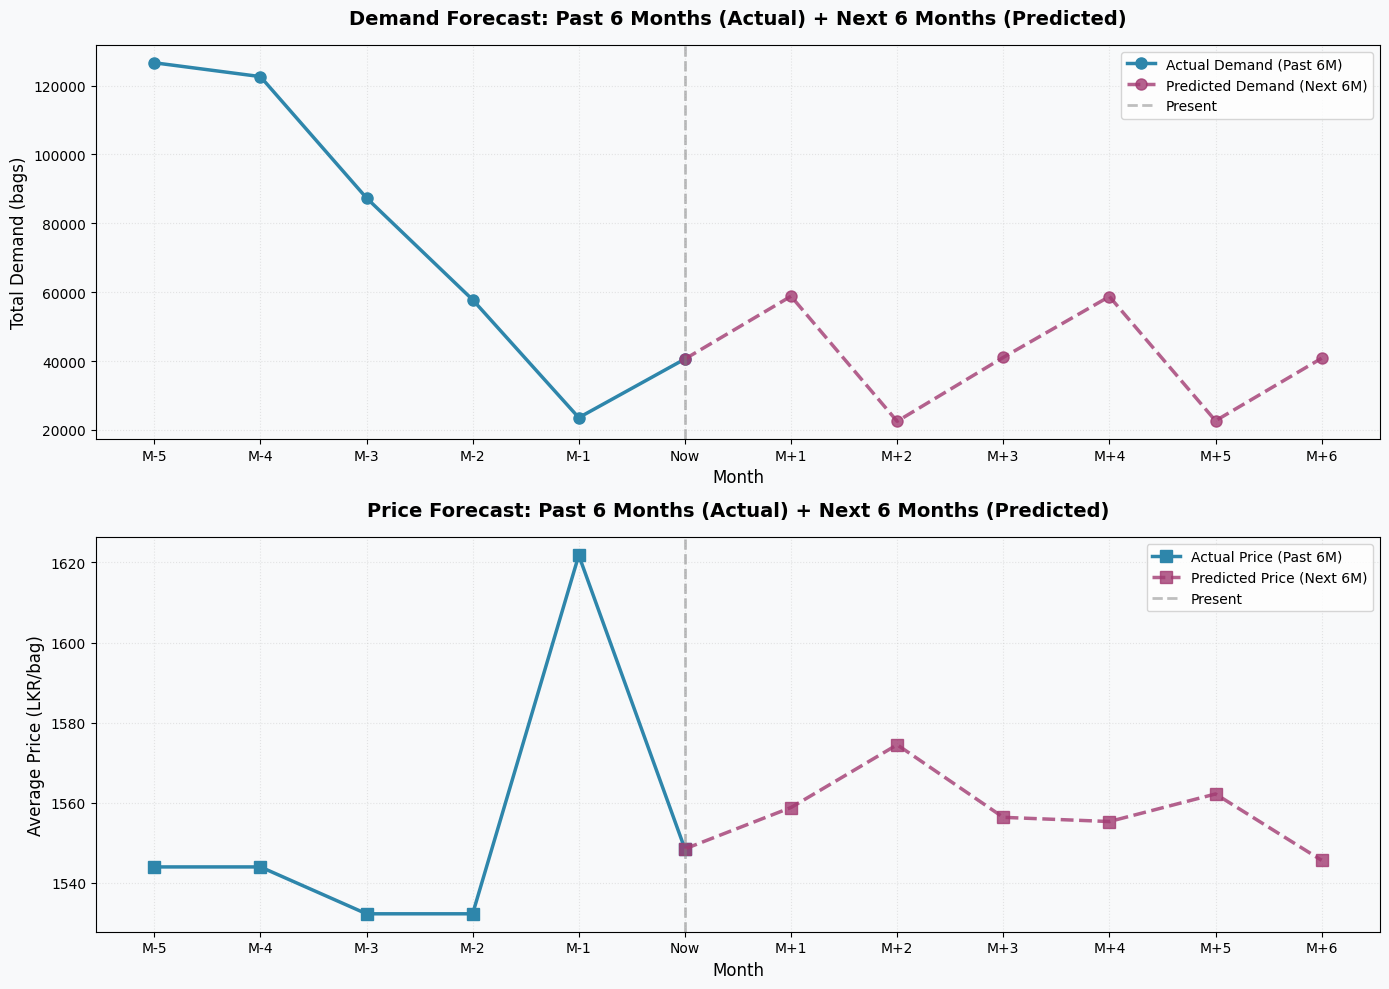


✅ Model 4 Visualization Complete


In [7]:
import matplotlib.pyplot as plt

"""
### Visualize Model 4: 6-Month Forecasting with Past & Future
"""

print("\n" + "="*60)
print("MODEL 4 VISUALIZATION & SAMPLE OUTPUTS")
print("="*60)

# 1. Generate 6-month recursive forecast using JSON function
print("\n🔮 Generating 6-Month Future Forecast...")

output_json_future = generate_future_predictions_json(
    create_prediction_input_json(forecast_months=6),
    model_demand,
    model_price_fc,
    scaler
)
future_demand = [d["value"] for d in output_json_future["predictions"]["demand"]]
future_prices = [p["value"] for p in output_json_future["predictions"]["price"]]

print("✓ 6-month forecast generated")

# 2. Display sample outputs
print("\n📥 Sample Outputs:")
print("\n📅 Future Demand Forecast (Next 6 Months):")
for i, demand in enumerate(future_demand, 1):
    print(f"   Month +{i}: {demand:,.0f} bags")

print("\n💰 Future Price Forecast (Next 6 Months):")
for i, price in enumerate(future_prices, 1):
    print(f"   Month +{i}: {price:.2f} LKR/bag")

# 3. Create visualization: 6M Past (Solid) + 6M Future (Dotted)
print("\n📊 Creating Enhanced Forecast Visualization...")

last_6_demand = df_forecast['total_demand_bags'].tail(6).values
last_6_prices = df_forecast['price_mean'].tail(6).values

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.patch.set_facecolor('#F8F9FA')

past_labels = ['M-5', 'M-4', 'M-3', 'M-2', 'M-1', 'Now']
future_labels = ['M+1', 'M+2', 'M+3', 'M+4', 'M+5', 'M+6']
all_labels = past_labels + future_labels

# DEMAND CHART
ax1 = axes[0]
ax1.set_facecolor('#F8F9FA')

ax1.plot(range(6), last_6_demand,
         marker='o', color='#2E86AB', linewidth=2.5,
         markersize=8, label='Actual Demand (Past 6M)', linestyle='-')

ax1.plot(range(5, 12), [last_6_demand[-1]] + future_demand,
         marker='o', color='#A23B72', linewidth=2.5,
         markersize=8, label='Predicted Demand (Next 6M)', linestyle='--', alpha=0.8)

ax1.axvline(x=5, color='gray', linestyle='--', linewidth=2, alpha=0.5, label='Present')

ax1.set_title('Demand Forecast: Past 6 Months (Actual) + Next 6 Months (Predicted)',
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Total Demand (bags)', fontsize=12)
ax1.set_xticks(range(12))
ax1.set_xticklabels(all_labels, fontsize=10)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle=':')

# PRICE CHART
ax2 = axes[1]
ax2.set_facecolor('#F8F9FA')

ax2.plot(range(6), last_6_prices,
         marker='s', color='#2E86AB', linewidth=2.5,
         markersize=8, label='Actual Price (Past 6M)', linestyle='-')

ax2.plot(range(5, 12), [last_6_prices[-1]] + future_prices,
         marker='s', color='#A23B72', linewidth=2.5,
         markersize=8, label='Predicted Price (Next 6M)', linestyle='--', alpha=0.8)

ax2.axvline(x=5, color='gray', linestyle='--', linewidth=2, alpha=0.5, label='Present')

ax2.set_title('Price Forecast: Past 6 Months (Actual) + Next 6 Months (Predicted)',
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Average Price (LKR/bag)', fontsize=12)
ax2.set_xticks(range(12))
ax2.set_xticklabels(all_labels, fontsize=10)
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle=':')

plt.tight_layout()
plt.show()

print(f"\n✅ Model 4 Visualization Complete")

In [8]:
# =============================================================================
# TEST DEMONSTRATION: FUTURE PREDICTIONS (Next 6 Months)
# =============================================================================

print("\n" + "="*80)
print("FUTURE PREDICTIONS TEST (Next 6 Months)")
print("="*80)

# Create input JSON
input_json_future = create_prediction_input_json(forecast_type='future', forecast_months=6)

# Generate predictions
output_json_future = generate_future_predictions_json(
    input_json_future,
    model_demand,
    model_price_fc,
    scaler
)

# Display Input JSON
print("\n📥 SAMPLE INPUT JSON:")
print("-" * 80)
# Show abbreviated version (only first 2 records of latest_data)
input_display = input_json_future.copy()
input_display['latest_data'] = input_display['latest_data'][:2] + [{'...': '...'}]
print(json.dumps(input_display, indent=2))

# Display Output JSON
print("\n📤 OUTPUT JSON:")
print("-" * 80)
print(json.dumps(output_json_future, indent=2))

# Display in tabular format for easier reading
print("\n📊 PREDICTIONS SUMMARY:")
print("-" * 80)
print(f"{'Month':<10} {'Demand (bags)':<20} {'Price (LKR/bag)':<20}")
print("-" * 80)
for i in range(6):
    month = output_json_future['predictions']['demand'][i]['month']
    demand = output_json_future['predictions']['demand'][i]['value']
    price = output_json_future['predictions']['price'][i]['value']
    print(f"{month:<10} {demand:<20,.0f} {price:<20.2f}")

print("\n" + "="*80)



FUTURE PREDICTIONS TEST (Next 6 Months)

📥 SAMPLE INPUT JSON:
--------------------------------------------------------------------------------
{
  "forecast_type": "future",
  "months": 6,
  "latest_data": [
    {
      "total_demand_bags": 760.0,
      "price_mean": 1544.0,
      "month": 1,
      "season_encoded": 1
    },
    {
      "total_demand_bags": 24730.0,
      "price_mean": 1544.0,
      "month": 2,
      "season_encoded": 1
    },
    {
      "...": "..."
    }
  ]
}

📤 OUTPUT JSON:
--------------------------------------------------------------------------------
{
  "predictions": {
    "demand": [
      {
        "month": "+1",
        "value": 58819.39,
        "month_offset": 1
      },
      {
        "month": "+2",
        "value": 22494.73,
        "month_offset": 2
      },
      {
        "month": "+3",
        "value": 41052.42,
        "month_offset": 3
      },
      {
        "month": "+4",
        "value": 58738.58,
        "month_offset": 4
      },
      {


In [9]:
# =============================================================================
# TEST DEMONSTRATION: PAST DATA (Last 6 Months)
# =============================================================================

print("\n" + "="*80)
print("PAST DATA TEST (Last 6 Months of Historical Data)")
print("="*80)

# Generate past data JSON
output_json_past = generate_past_predictions_json(forecast_months=6)

# Display Output JSON
print("\n📤 OUTPUT JSON:")
print("-" * 80)
print(json.dumps(output_json_past, indent=2))

# Display in tabular format
print("\n📊 HISTORICAL DATA SUMMARY:")
print("-" * 80)
print(f"{'Month':<10} {'Demand (bags)':<20} {'Price (LKR/bag)':<20}")
print("-" * 80)
for i in range(6):
    month = output_json_past['predictions']['demand'][i]['month']
    demand = output_json_past['predictions']['demand'][i]['actual_value']
    price = output_json_past['predictions']['price'][i]['actual_value']
    print(f"{month:<10} {demand:<20,.0f} {price:<20.2f}")

print("\n" + "="*80)
print("✅ All tests completed successfully!")
print("="*80)



PAST DATA TEST (Last 6 Months of Historical Data)

📤 OUTPUT JSON:
--------------------------------------------------------------------------------
{
  "predictions": {
    "demand": [
      {
        "month": "-6",
        "actual_value": 126633.0,
        "month_offset": -6
      },
      {
        "month": "-5",
        "actual_value": 122615.0,
        "month_offset": -5
      },
      {
        "month": "-4",
        "actual_value": 87360.0,
        "month_offset": -4
      },
      {
        "month": "-3",
        "actual_value": 57800.0,
        "month_offset": -3
      },
      {
        "month": "-2",
        "actual_value": 23553.0,
        "month_offset": -2
      },
      {
        "month": "-1",
        "actual_value": 40587.0,
        "month_offset": -1
      }
    ],
    "price": [
      {
        "month": "-6",
        "actual_value": 1544.0,
        "month_offset": -6
      },
      {
        "month": "-5",
        "actual_value": 1544.0,
        "month_offset": -5
   